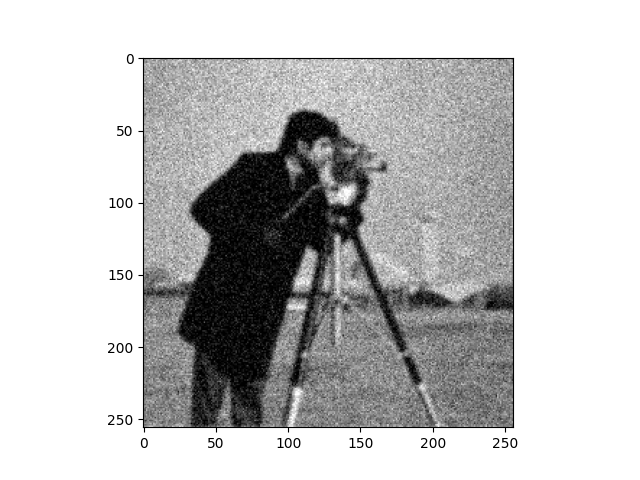

In [1]:
%matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration
import skimage.filters.rank as rank


plt.gray()

def PSNR(f: np.ndarray, g: np.ndarray):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))

class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self, eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]

    def get_bbox(self):
        return self.bbox


f = imread('cameraman.tiff').astype(np.float64)/255
I = imread('degraded.tif').astype(np.float64)/255
plt.imshow(I)
plt.show()

# 2 Image Restoration in the Frequency Domain

Blurred image (PSNR = 16.31)


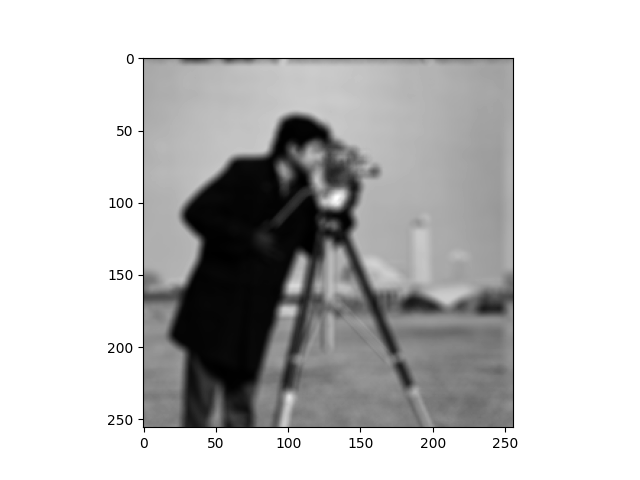

Inverted image (PSNR = 316.61)


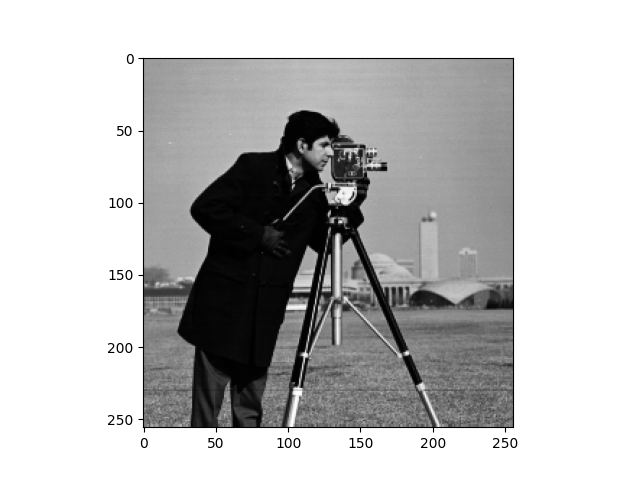

In [2]:
#Image Restoration in Freq Domain
h_d = disk(4) 
h = np.zeros((256,256)) 
h[0:9,0:9] = h_d / np.sum(h_d)
h = np.roll(h, (-5,-5)) 
h_freq = np.fft.fft2(h) 
f_blurfreq = h_freq*np.fft.fft2(f) 
f_blur = np.real(np.fft.ifft2(f_blurfreq))
f_inverted_freq = f_blurfreq/h_freq
f_inverted = np.real(np.fft.ifft2(f_inverted_freq))

print(f"Blurred image (PSNR = {PSNR(f_blur, f):.2f})")
plt.imshow(f_blur)
plt.show()
print(f"Inverted image (PSNR = {PSNR(f_inverted, f):.2f})")
plt.imshow(f_inverted)
plt.show()

Noisy image inverted (PSNR = -30.02)


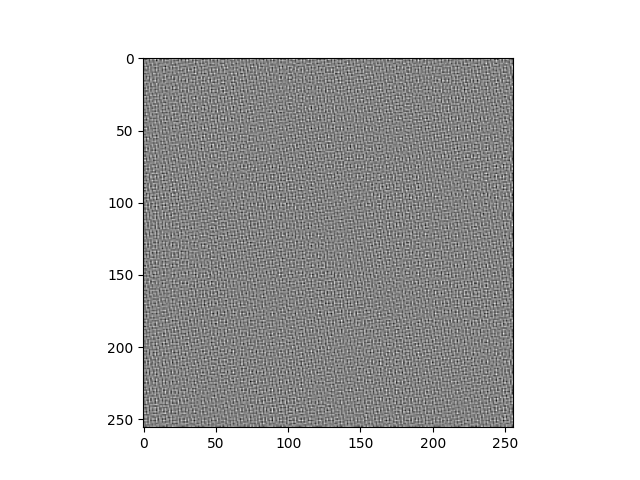

In [3]:
# Now add zero-mean Gaussian noise with a variance of 0.002
f_noisy = skimage.util.random_noise(f_blur, mode='gaussian', clip=True, var=0.0002)
f_noisy_freq = np.fft.fft2(f_noisy)

# Apply inverse filtering to the noisy blurred image.
f_noisy_inverted_freq = f_noisy_freq/h_freq
f_noisy_inverted = np.real(np.fft.ifft2(f_noisy_inverted_freq))
# Plot the restored image and the PSNR
print(f"Noisy image inverted (PSNR = {PSNR(f_noisy_inverted, f):.2f})")
plt.imshow(f_noisy_inverted)
plt.show()

Wiener filter (PSNR = 18.32)


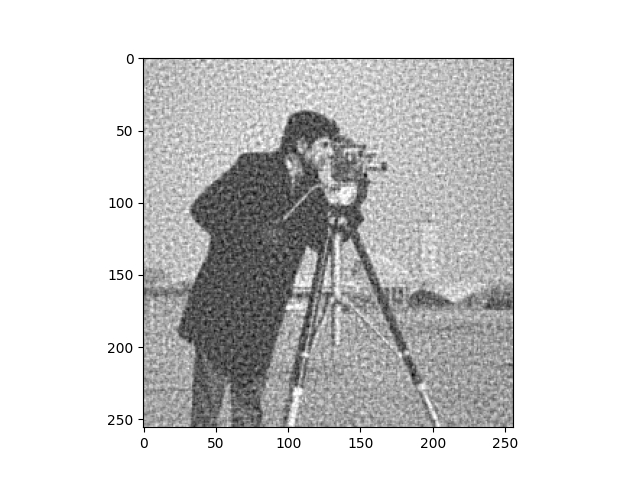

In [5]:
f_wiener_freq = restoration.wiener(f_noisy, np.fft.fftshift(h), 0.0002)
print(f"Wiener filter (PSNR = {PSNR(f_wiener_freq, f):.2f})")
plt.imshow(f_wiener_freq)
plt.show()

# 3. Adaptive Filtering